<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [2]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

from bs4 import BeautifulSoup

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [4]:
df = pd.read_csv('./data/job_listings.csv')
print(df.shape)
df.head()

(426, 3)


,Unnamed: 0,description,title
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


In [5]:
df = df.drop(columns='Unnamed: 0')

In [6]:
df.head()

,description,title
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


In [107]:
# notes from afterhours 
# requirements = job_desc.split("Job Requirements:")[1:][0]
# print(requirements)

# job = job.split("\n")
# for id_, line in enumerate(job):

#     if "Job Requirements" in line:
#         print(id_)

In [7]:
# file = df['description'][0]
# soup = BeautifulSoup(file,'html.parser')
# result = soup.get_text(strip=True)
# result = result.replace("\\n", "").replace("\n", "")
# print(result)

In [8]:
# way to complex for this haha
# desc_list = []
    
# for row in df['description']:
#     soup = BeautifulSoup(row,'html.parser')
#     result = soup.get_text(strip=True)
#     clean_result = result.replace("\\n", "").replace("\n", "")
#     desc_list.append(clean_result)
# print(desc_list)

In [10]:
import requests
from lxml import html 

# convert https to dataframe 

# from bs4 import BeautifulSoup
# import requests
# import pandas as pd 

# url = "https://markets.on.nytimes.com/research/markets/holidays/holidays.asp?display=market&exchange=SGO"

# res = requests.get(url)
# soup = BeautifulSoup(res.text, "lxml")
# data = pd.DataFrame()

# for rows in soup.find(id='holidayTable').find_all('tr')[1:]:
#     tds = [row.text for row in rows.find_all('td')]
#     add_list_to_df = pd.DataFrame([tds])
#     data = data.append(add_list_to_df)

# df = pd.DataFrame({"Header1":data[0],"Header2":data[1],"Header3":data[2],"Header4":data[3]}).to_string(index=False)
# print(df)

In [12]:
def clean_desc(desc):
    soup = BeautifulSoup(desc, 'html.parser')
    #soup.prettify()
    return soup.get_text()

df['description'] = df['description'].apply(clean_desc)

(426, 2)

In [14]:
df.head()

,description,title
0,"b""Job Requirements:\nConceptual understanding ...",Data scientist
1,"b'Job Description\n\nAs a Data Scientist 1, yo...",Data Scientist I
2,b'As a Data Scientist you will be working on c...,Data Scientist - Entry Level
3,"b'$4,969 - $6,756 a monthContractUnder the gen...",Data Scientist
4,b'Location: USA \xe2\x80\x93 multiple location...,Data Scientist


## 2) Use Spacy to tokenize the listings 

In [17]:
from spacy.tokenizer import Tokenizer

#model
nlp = spacy.load("en_core_web_lg")

# STOP_WORDS = nlp.Defaults.stop_words.union([' '])

In [18]:
# make basic tokens
def tokenize(text):
    doc = nlp(text)
    lemma_tokens = [token.lemma_ for token in doc if (token.is_stop !=True) and (token.is_punct != True)]

    return lemma_tokens

In [19]:
df['lemmas'] = df['description'].apply(tokenize)

In [20]:
df.head()

,description,title,lemmas
0,"b""Job Requirements:\nConceptual understanding ...",Data scientist,"[b""Job, requirements:\nconceptual, understandi..."
1,"b'Job Description\n\nAs a Data Scientist 1, yo...",Data Scientist I,"[b'Job, description\n\na, Data, scientist, 1, ..."
2,b'As a Data Scientist you will be working on c...,Data Scientist - Entry Level,"[b'As, Data, scientist, work, consult, busines..."
3,"b'$4,969 - $6,756 a monthContractUnder the gen...",Data Scientist,"[b'$4,969, $, 6,756, monthcontractunder, gener..."
4,b'Location: USA \xe2\x80\x93 multiple location...,Data Scientist,"[b'Location, USA, \xe2\x80\x93, multiple, loca..."


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [21]:
##### Your Code Here #####

from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=1000) # also have min_df=.03 or ngram_range=(1,2)

#Learn our Vocab
vect.fit(df)

# Get sparse dtm
dtm = vect.transform(df)
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())

In [24]:
dtm.head()

,description,lemmas,title
0,1,0,0
1,0,0,1
2,0,1,0


In [25]:
# function for countvectorizer
def vect_word_count(text):
    vect = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=1000)
    vect.fit(text)
    dtm = vect.transform(text)
    return len(vect.get_feature_names())

In [26]:
df['wc'] = df['lemmas'].apply(vect_word_count)
df.head()

,description,title,lemmas,wc
0,"b""Job Requirements:\nConceptual understanding ...",Data scientist,"[b""Job, requirements:\nconceptual, understandi...",88
1,"b'Job Description\n\nAs a Data Scientist 1, yo...",Data Scientist I,"[b'Job, description\n\na, Data, scientist, 1, ...",331
2,b'As a Data Scientist you will be working on c...,Data Scientist - Entry Level,"[b'As, Data, scientist, work, consult, busines...",74
3,"b'$4,969 - $6,756 a monthContractUnder the gen...",Data Scientist,"[b'$4,969, $, 6,756, monthcontractunder, gener...",138
4,b'Location: USA \xe2\x80\x93 multiple location...,Data Scientist,"[b'Location, USA, \xe2\x80\x93, multiple, loca...",32


## 4) Visualize the most common word counts

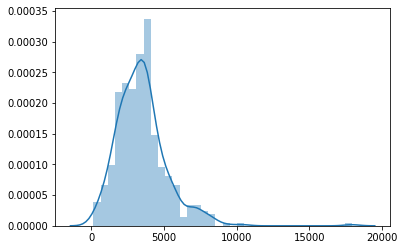

In [30]:
##### sns plot #####
import seaborn as sns
data = [d for d in df['description']]
doc_len = [len(doc) for doc in data]
sns.distplot(doc_len);

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

# instatiate vector object
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,2))

# create vocab and get word counts per document
# similar to fit predict
dtm = tfidf.fit_transform(data)

# print(dtm)

  (0, 25662)	0.10165652290222262
  (0, 67605)	0.09517938190057869
  (0, 58808)	0.10165652290222262
  (0, 63612)	0.10165652290222262
  (0, 12775)	0.026641028768749863
  (0, 39441)	0.05687397539702527
  (0, 68673)	0.05548400386497748
  (0, 17095)	0.0633511163986692
  (0, 46943)	0.0648736579469791
  (0, 5114)	0.10165652290222262
  (0, 58251)	0.10165652290222262
  (0, 34956)	0.10165652290222262
  (0, 27906)	0.10165652290222262
  (0, 77782)	0.10165652290222262
  (0, 52667)	0.09517938190057869
  (0, 47127)	0.10165652290222262
  (0, 35533)	0.10165652290222262
  (0, 57273)	0.0578727127964791
  (0, 65669)	0.09517938190057869
  (0, 29965)	0.10165652290222262
  (0, 67882)	0.07303389054460717
  (0, 24288)	0.07057139582243722
  (0, 46126)	0.07303389054460717
  (0, 30012)	0.10165652290222262
  (0, 68080)	0.10165652290222262
  :	:
  (425, 38094)	0.01919260584738928
  (425, 63391)	0.0162410141774764
  (425, 12766)	0.020903408061250146
  (425, 39434)	0.02548753285434551
  (425, 68630)	0.019789428386657

In [32]:
# get feature names for dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

dtm.head()

,00,00 npreferred,000,000 100,000 125,000 350,000 85,000 annually,000 associates,000 cities,...,zones,zones nability,zoom,zoom understand,zuckerberg,zuckerberg 2015,zuckerberg initiative,zurich,zurich american,zurich customers
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [33]:
from sklearn.neighbors import NearestNeighbors

# Fit on DTM
nn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree') # can use kd_tree too
nn.fit(dtm)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [34]:
data[256][:200]

"b'Role Summary:\\nThe CCS Data Scientist is responsible for supporting the CCS digital service operations teams with data analytics that drive improved remote service efficiency and improved customer e"

In [37]:
dream_role = [ """
This is a research analyst role where you'll have to analyst cryptoasset and blockchain data on a daily basis. Math is not a four letter word
and you'll be responsible for performing all types of analysis of our queryed data. You must know SQL, pandas, numpy, basic data vizualizations, as well
as have a in depth knowledge of cryptoasset fundamentals. You know that there is more to a blockchain that just blocks. 
""" ] 

In [38]:
new = tfidf.transform(dream_role)

In [39]:
new

<1x79927 sparse matrix of type '<class 'numpy.float64'>'
	with 35 stored elements in Compressed Sparse Row format>

In [40]:
nn.kneighbors(new.todense())

(array([[1.34450501, 1.34935685, 1.37705838, 1.37894599, 1.38315588]]),
 array([[289, 249, 387, 111, 401]]))

In [41]:
data[401]

'b"about dscout\\nWe are dscout. At our core, we are People Nerds. We empower our customers to meet the people who matter to them in the moments that matter most. Many of the world\'s most influential tech companies use dscout to deliver better products and services, alongside customer-obsessed companies and agencies like Lyft, Nike, IDEO, and REI.\\nProduct and UX experience professionals use our platform to build, field, and analyze user research via our web-based platform while scouts (research participants) share in-context moments from our native mobile apps on iOS and Android. For example, in the past 30 days we\'ve conducted close to 500 research missions, had over 40,000 entries submitted by our scouts, and conducted over 500 real-time video user interviews.\\nour platform\\nOur platform is built on cutting edge technology with React.js frontend and Elixir backend tied together by GraphQL APIs with a small part done in Ruby/Rails and REST APIs. We make heavy use of PostgreSQL a

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 